# Pneumonia Detection Project

We have sone Image classification of X_ray images

Here two approaches are used one using CNN and VGG16.

VGG16 is existing model of convolution neural networks.

We used it for transfer learning.

## Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/X_ray_PNUEMONIA_Detection.zip'

Archive:  /content/gdrive/MyDrive/DBDA/PG-DBDA FEB 2025/Study Material/Practical Machine Learning/Day10_CNN/X_ray_PNUEMONIA_Detection.zip
  inflating: X_ray_PNUEMONIA_Detection/Pneumonia_detection_using_Transfer_Learning.ipynb  
  inflating: X_ray_PNUEMONIA_Detection/test_small.zip  
  inflating: X_ray_PNUEMONIA_Detection/train_small.zip  


In [ ]:
!unzip '/content/X_ray_PNUEMONIA_Detection/train_small.zip'

Archive:  /content/X_ray_PNUEMONIA_Detection/train_small.zip
replace train_small/NORMAL/IM-0115-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/NORMAL/IM-0115-0001.jpeg  
replace train_small/NORMAL/IM-0117-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/NORMAL/IM-0117-0001.jpeg  
replace train_small/NORMAL/IM-0119-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/NORMAL/IM-0119-0001.jpeg  
replace train_small/NORMAL/IM-0122-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/NORMAL/IM-0122-0001.jpeg  
replace train_small/NORMAL/IM-0125-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/NORMAL/IM-0125-0001.jpeg  
replace train_small/NORMAL/IM-0127-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/NORMAL/IM-0127-0001.jpeg  
replace train_small/NORMAL/IM-0128-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_small/

In [ ]:
!unzip '/content/X_ray_PNUEMONIA_Detection/test_small.zip'

Archive:  /content/X_ray_PNUEMONIA_Detection/test_small.zip
   creating: test_small/
   creating: test_small/NORMAL/
  inflating: test_small/NORMAL/IM-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0003-0001.jpeg  
  inflating: test_small/NORMAL/IM-0005-0001.jpeg  
  inflating: test_small/NORMAL/IM-0006-0001.jpeg  
  inflating: test_small/NORMAL/IM-0007-0001.jpeg  
  inflating: test_small/NORMAL/IM-0009-0001.jpeg  
  inflating: test_small/NORMAL/IM-0010-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001.jpeg  
  inflating: test_small/NORMAL/IM-0013-0001.jpeg  
  inflating: test_small/NORMAL/IM-0015-0001.jpeg  
  inflating: test_small/NORMAL/IM-0016-0001.jpeg  
  inflating: test_small/NORMAL/IM-0017-0001.jpeg  
  inflating: test_small/NORMAL/IM-0019-0001.jpeg  
  inflating: test_small/NORMAL/IM-0021-0001.jpeg  
  inflating: test_small/NORMAL/IM-0022-0001.jpeg  
  infl

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import os
import pandas as pd

In [ ]:
# VGG model requires 224*224 input so we are going to re-size all images
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = 'train_small'
valid_path = 'test_small'

# LOad Data by Generator

Generator can create random variations in the given images for generalization of training

In [ ]:
# example of progressively loading images from file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
# generator applied random preprocessing to make the model --> robust
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2, # every image will be randomly distorted 0-0.2
                             zoom_range = 0.2, # every image will be randomly zoomed 0-0.2
                             horizontal_flip = True, #
                             vertical_flip=True,
                             rotation_range=30) #every image will be randomly ratated 0-30 degree
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( './train_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
val_it = datagen.flow_from_directory('./test_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
test_it = datagen.flow_from_directory('./test_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
# confirm the iterator works
batchX, batchy = next(train_it)
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 101 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Batch shape=(2, 224, 224, 3), min=0.000, max=0.999


# Create Simple CNN model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input
from tensorflow.keras import Sequential

In [ ]:
model = Sequential()
model.add(Input((224,224,3)))
model.add(Conv2D(32, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES
model.add(Conv2D(64, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(128, (5,5),padding='valid',activation='relu'))
# model.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
# any no of dense layers
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
5*5*32*64+64

51264

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 51, 51, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,714 (5.02 MB)

 Trainable params: 1,315,714 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_it,
  validation_data=val_it,
  epochs=5)

Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8666 - loss: 0.3932 - val_accuracy: 0.6304 - val_loss: 0.7554
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8625 - loss: 0.5287 - val_accuracy: 0.3696 - val_loss: 0.7752
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7804 - loss: 0.5167 - val_accuracy: 0.4130 - val_loss: 2.1918
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7660 - loss: 0.5059 - val_accuracy: 0.5652 - val_loss: 0.8272
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7733 - loss: 0.5371 - val_accuracy: 0.5870 - val_loss: 1.1469


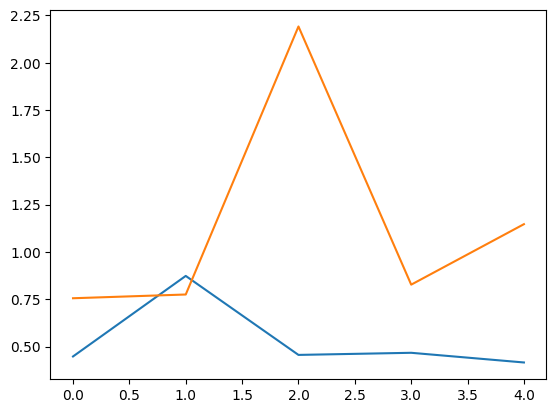

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# VGG16 Model (Transfer Learning)

#### add preprocessing layer to the front of VGG
#### [3] add 3 Channles ie RGB
#### We are importing weights from imagenet use it as it is
#### include_top means we last layer in VGG16 Model we dont want this
#### Because with help of VGG we are tyring to solve own problem

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


## Don't train existing weights

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

# Add Our Layers at End of VGG16

In [ ]:
output_classes = 2

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
# x = Dense(500, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history_vgg= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
)

Epoch 1/5
51/51 [==============================] - 7s 95ms/step - loss: 2.0798 - accuracy: 0.8020 - val_loss: 0.4821 - val_accuracy: 0.8913
Epoch 2/5
51/51 [==============================] - 4s 80ms/step - loss: 0.5406 - accuracy: 0.9010 - val_loss: 2.8992 - val_accuracy: 0.6957
Epoch 3/5
51/51 [==============================] - 4s 82ms/step - loss: 0.6879 - accuracy: 0.9109 - val_loss: 3.5966 - val_accuracy: 0.6522
Epoch 4/5
51/51 [==============================] - 4s 83ms/step - loss: 0.4407 - accuracy: 0.9010 - val_loss: 3.5942 - val_accuracy: 0.6739
Epoch 5/5
51/51 [==============================] - 5s 102ms/step - loss: 0.4897 - accuracy: 0.9307 - val_loss: 0.9480 - val_accuracy: 0.7826


In [ ]:
history_vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

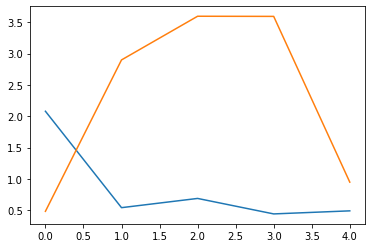

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])

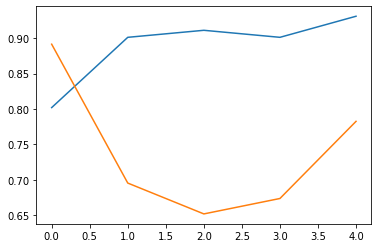

In [ ]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])

# Resnet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
resnet = ResNet50(include_top=True,weights="imagenet",input_shape=(224,224,3),classes=1000)

102967424/102967424 [==============================] - 3s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in resnet.layers[:-2]:
  layer.trainable = False

# Add Our Layers at End of Resnet50

In [ ]:
output_classes = 2

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.layers[-2].output)
# x = Dense(5000, activation='relu')(x)
# x = Dense(500, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history_resnet= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
  )

Epoch 1/5
51/51 [==============================] - 10s 135ms/step - loss: 0.5525 - accuracy: 0.7525 - val_loss: 0.8948 - val_accuracy: 0.5000
Epoch 2/5
51/51 [==============================] - 4s 84ms/step - loss: 0.5387 - accuracy: 0.7723 - val_loss: 0.7434 - val_accuracy: 0.5000
Epoch 3/5
51/51 [==============================] - 4s 81ms/step - loss: 0.5249 - accuracy: 0.7723 - val_loss: 0.8620 - val_accuracy: 0.5000
Epoch 4/5
51/51 [==============================] - 4s 81ms/step - loss: 0.5300 - accuracy: 0.7723 - val_loss: 0.8459 - val_accuracy: 0.5000
Epoch 5/5
51/51 [==============================] - 4s 82ms/step - loss: 0.5201 - accuracy: 0.7723 - val_loss: 0.7389 - val_accuracy: 0.5000


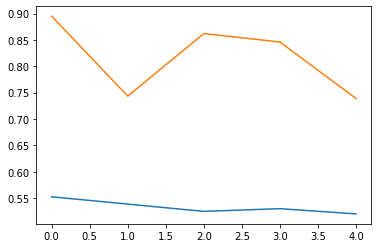

In [ ]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])

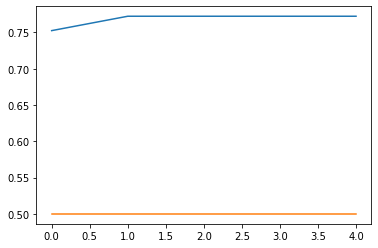

In [ ]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])

In [ ]:
model = Sequential()
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# any no of dense layers
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model = Sequential()
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3,3),padding='valid',activation='relu'))

model.add(Conv2D(64, (3,3),padding='valid',activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, (5,5),padding='valid',activation='relu'))

model.add(Conv2D(64, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# any no of dense layers
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 69, 69, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 65, 65, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,519,010 (32.50 MB)

 Trainable params: 8,519,010 (32.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3,3),padding='valid',activation='relu'))

model.add(Conv2D(64, (3,3),padding='valid',activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, (5,5),padding='valid',activation='relu'))

model.add(Conv2D(64, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# any no of dense layers
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='softmax'))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 69, 69, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 65, 65, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,521,522 (32.51 MB)

 Trainable params: 8,521,522 (32.51 MB)

 Non-trainable params: 0 (0.00 B)